In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from matplotlib import style
from scipy import stats

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


#### get ALK control

In [2]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'

In [3]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.0001-0062.nc'
ds_1 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [4]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.0063-0124.nc'
ds_2 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [5]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.0125-0186.nc'
ds_3 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [6]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.0187-0248.nc'
ds_4 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [7]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.0249-0310.nc'
ds_5 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [8]:
ds_alk = xr.concat([ds_1, ds_2, ds_3, ds_4, ds_5], 'time')

#### get ALK noGCB

In [9]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0001-0062.nc'
ds_1 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [10]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0063-0124.nc'
ds_2 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [11]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0125-0186.nc'
ds_3 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [12]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0187-0248.nc'
ds_4 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [13]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0249-0310.nc'
ds_5 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [14]:
ds_alk_noGCB = xr.concat([ds_1, ds_2, ds_3, ds_4, ds_5], 'time')

#### get ALK 2xGCB

In [15]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'

In [16]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0001-0062.nc'
ds_1 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [17]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0063-0124.nc'
ds_2 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [18]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0125-0186.nc'
ds_3 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [19]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0187-0248.nc'
ds_4 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [20]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0249-0310.nc'
ds_5 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [21]:
ds_alk_2xGCB = xr.concat([ds_1, ds_2, ds_3, ds_4, ds_5], 'time')

#### get the WOA for coords

In [22]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [23]:
ds_woa['z_t'] = ds_alk.z_t
tlen=len(ds_alk.time)
tlen

310

In [24]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
years = np.arange(1,tlen+1)
z_top=depths[0:40]
z_bottom=depths[40:60]

#### Get major basin masks

In [25]:
grid_name = 'POP_gx1v7'

region_mask='Pacific-Indian-Atlantic'
mask3d_basins = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

region_mask='lat-range-basin'
mask3d_regs = pop_tools.region_mask_3d(grid_name, mask_name=region_mask) #southern ocean is reg 1

#### Global timeseries

In [27]:
%%time
ts_global = xr.Dataset({v: ds_alk[v] for v in ['time','z_t']})
ts_global['ALK'] = esmlab.weighted_mean(ds_alk['ALK'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['ALK_noGCB'] = esmlab.weighted_mean(ds_alk_noGCB['ALK_ALT_CO2'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['ALK_2xGCB'] = esmlab.weighted_mean(ds_alk_2xGCB['ALK_ALT_CO2'], weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 1min 34s, sys: 4min 6s, total: 5min 41s
Wall time: 9min 48s


In [28]:
alk_noGCBdiff_global = ts_global['ALK_noGCB'] - ts_global['ALK']
alk_noGCBdiff_global = alk_noGCBdiff_global.transpose()
alk_noGCBdiff_global_top = alk_noGCBdiff_global.isel(z_t=slice(0,40))
alk_noGCBdiff_global_bottom = alk_noGCBdiff_global.isel(z_t=slice(40,60))

In [29]:
alk_2xGCBdiff_global = ts_global['ALK_2xGCB'] - ts_global['ALK']
alk_2xGCBdiff_global = alk_2xGCBdiff_global.transpose()
alk_2xGCBdiff_global_top = alk_2xGCBdiff_global.isel(z_t=slice(0,40))
alk_2xGCBdiff_global_bottom = alk_2xGCBdiff_global.isel(z_t=slice(40,60))

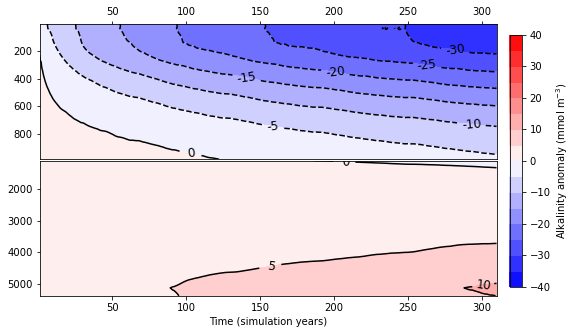

In [44]:
levels = [-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40]

fig = plt.figure(figsize=(9,5))
#plt.suptitle('a) Global Alk difference over time: 2xGCB', fontsize=14)

ax = fig.add_subplot(2,1,1)

pc=ax.contourf(years, z_top, alk_2xGCBdiff_global_top, levels, cmap='bwr')
contour = plt.contour(years, z_top, alk_2xGCBdiff_global_top, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
#ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, alk_2xGCBdiff_global_bottom, levels, cmap='bwr')
contour = plt.contour(years, z_bottom, alk_2xGCBdiff_global_bottom, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.83,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity anomaly (mmol m$^{-3}$)')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/global_alkdiff_hof_2xGCB.pdf', bbox_inches='tight', format='pdf');


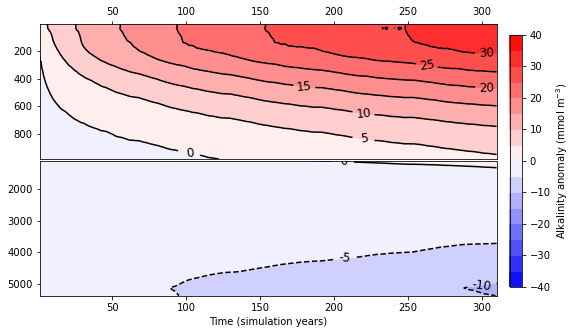

In [45]:
levels = [-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40]

fig = plt.figure(figsize=(9,5))
#plt.suptitle('a) Global Alk difference over time: noGCB', fontsize=14)

ax = fig.add_subplot(2,1,1)

pc=ax.contourf(years, z_top, alk_noGCBdiff_global_top, levels, cmap='bwr')
contour = plt.contour(years, z_top, alk_noGCBdiff_global_top, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
#ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, alk_noGCBdiff_global_bottom, levels, cmap='bwr')
contour = plt.contour(years, z_bottom, alk_noGCBdiff_global_bottom, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set( xlabel='Time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.83,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity anomaly (mmol m$^{-3}$)')

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/global_alkdiff_hof_noGCB.pdf', bbox_inches='tight', format='pdf');
